In [86]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cycler
import MetaTrader5 as mt5
import warnings

warnings.filterwarnings("ignore")

In [88]:
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

In [89]:
# Time
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2000, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
# Metatrader 5 Darwinex ETF
if mt5.initialize():
    symbols = mt5.symbols_get()
    list_tickers = [symbol.name for symbol in symbols if "ETF" in symbol.path]
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_MN1, time_from, time_to) for ticker in list_tickers]
    df = pd.DataFrame()
    for ticker, data in zip(list_tickers, database):
        temp_df = pd.DataFrame(data['close'], index=data['time'], columns=[ticker])
        df = pd.concat([df, temp_df], axis=1)
    df.index.names = ['time']
    df.index = pd.to_datetime(df.index, unit='s')
    data = df.dropna()

In [90]:
# Calcular el periodo de espera y el periodo de retención 
# (Se calcula el rendimiento anual pasado con el mensual siguiente)
for col in list_tickers:
    data[f'pct+1 {col}'] = data[col].pct_change(-1)
    data[f'pct-12 {col}'] = data[col].pct_change(12)

In [91]:
# Split de datos
split = int(0.6 * len(data))
train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]

In [92]:
# Cálculo de la correlación
corr = []
for col in list_tickers:
    cor = train_set[[f'pct-12 {col}', f'pct+1 {col}']].corr().values[0][1]
    corr.append(cor)
correlation = pd.DataFrame(corr, index=list_tickers, columns=["Corr"])
correlation = correlation.sort_values(by="Corr", ascending=False)
# Seleccionar los mejores activos
best_tickers = list(correlation.loc[correlation['Corr'] > 0.15].index)

In [93]:
# Encontrar los vectores mean y std
columns = [f'pct-12 {col}' for col in best_tickers]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

In [94]:
# Crear los z-scores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std
# Encontrar las medianas
median = train_set[columns].median()

<Axes: xlabel='time'>

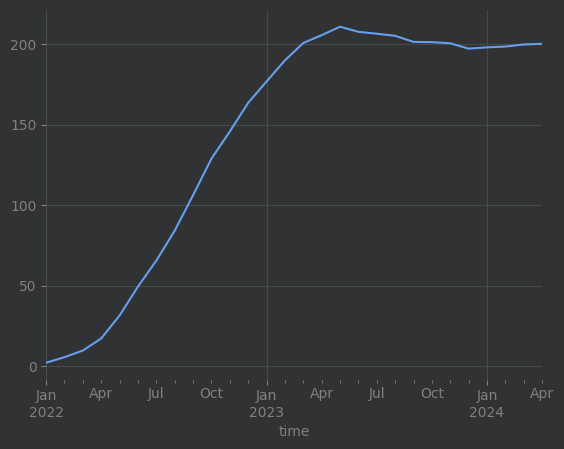

In [95]:
# Señales y beneficios
for i in range(len(columns)):
    # Columna para señal
    test_set[f'signal {columns[i]}'] = 0
    # -1 si z-score < median
    test_set.loc[test_set[f'{columns[i]}'] < median[i], f'signal {columns[i]}'] = -1
    # 1 si z-score > median
    test_set.loc[test_set[f'{columns[i]}'] > median[i], f'signal {columns[i]}'] = 1
    # Beneficio operación
    test_set[f'profit {columns[i]}'] = (test_set[f'signal {columns[i]}'].shift(1)) *\
        test_set[f'pct-12 {list_tickers[i]}']
# Visualizar
test_set.filter(regex='^profit').dropna().cumsum().sum(axis=1).plot()